[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# State Schema 

## Review

In module 1, we laid the foundations! We built up to an agent that can: 

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions
 
And, we showed how to serve it locally in LangGraph Studio or deploy it with LangGraph Cloud. 

## Goals

In this module, we're going to build a deeper understanding of both state and memory.

First, let's review a few different ways to define your state schema.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

## TypedDict

As we mentioned in Module 1, we can use the `TypedDict` class from python's `typing` module.

It allows you to specify keys and their corresponding value types.
 
But, note that these are type hints. 

They can be used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run. 

But they are not enforced at runtime!

In [2]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints, you can use things like the `Literal` type hint.

Here, `mood` can only be either "happy" or "sad".

In [7]:
from typing import Literal, TypedDict

class TypedDictState(TypedDict):
    name: str
    genre: Literal["horror", "science fiction", "fantasy"]
    reading_time: Literal["short", "long"]

We can use our defined state class (e.g., here `TypedDictState`) in LangGraph by simply passing it to `StateGraph`.

And, we can think about each state key as just a "channel" in our graph. 

As discussed in Module 1, we overwrite the value of a specified key or "channel" in each node.

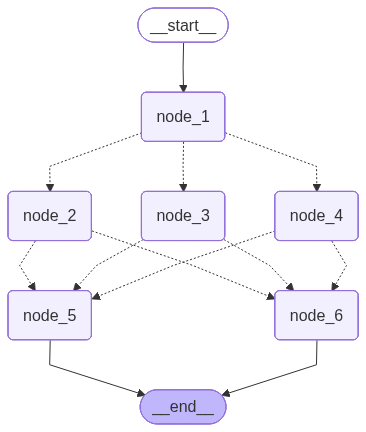

In [8]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1:Lets pick a book to read---")
    return {"name": state['name'] + " is browsing the library... "}

def node_2(state):
    print("---Node 2: Horror Section---")
    return {"genre": "horror"}

def node_3(state):
    print("---Node 3: Science Fiction Section---")
    return {"genre": "science fiction"}

def node_4(state):
    print("---Node 4: Fantasy Section---")
    return {"genre": "fantasy"}

def node_5(state):
    print("---Node 5: Quick Read---")
    return {"reading_time": "short"}

def node_6(state):
    print("---Node 6: Long Read---")
    return {"reading_time": "long"}

def decide_genre(state) -> Literal["node_2", "node_3", "node_4"]:
    """
    Randomly choose between horror, science fiction, or fantasy
    """
    rand = random.random()
    
    if rand < 0.33:
        return "node_2"  # Horror
    elif rand < 0.66:
        return "node_3"  # Science Fiction
    else:
        return "node_4"  # Fantasy

def decide_reading_time(state) -> Literal["node_5", "node_6"]:
    """
    Randomly choose between quick read or long read
    """
    if random.random() < 0.5:
        return "node_5"  # Quick read
    else:
        return "node_6"  # Long read

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)
builder.add_node("node_5", node_5)
builder.add_node("node_6", node_6)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_genre)
builder.add_conditional_edges("node_2", decide_reading_time)
builder.add_conditional_edges("node_3", decide_reading_time)
builder.add_conditional_edges("node_4", decide_reading_time)
builder.add_edge("node_5", END)
builder.add_edge("node_6", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Because our state is a dict, we simply invoke the graph with a dict to set an initial value of the `name` key in our state.

In [9]:
graph.invoke({"name":"Riya"})

---Node 1:Lets pick a book to read---
---Node 4: Fantasy Section---
---Node 6: Long Read---


{'name': 'Riya is browsing the library... ',
 'genre': 'fantasy',
 'reading_time': 'long'}

In [10]:
graph.invoke({"name":"Riya"})

---Node 1:Lets pick a book to read---
---Node 2: Horror Section---
---Node 5: Quick Read---


{'name': 'Riya is browsing the library... ',
 'genre': 'horror',
 'reading_time': 'short'}

In [11]:
graph.invoke({"name":"Riya"})

---Node 1:Lets pick a book to read---
---Node 3: Science Fiction Section---
---Node 5: Quick Read---


{'name': 'Riya is browsing the library... ',
 'genre': 'science fiction',
 'reading_time': 'short'}

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [12]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    genre: Literal["horror", "science fiction", "fantasy"]
    reading_time: Literal["short", "long"]

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`: 

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.
 
This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

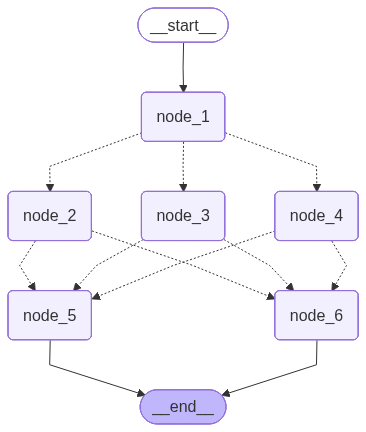

In [18]:
def node_1(state):
    print("---Node 1:Lets pick a book to read---")
    return {"name": state.name + " is browsing the library... "}


# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)
builder.add_node("node_5", node_5)
builder.add_node("node_6", node_6)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_genre)
builder.add_conditional_edges("node_2", decide_reading_time)
builder.add_conditional_edges("node_3", decide_reading_time)
builder.add_conditional_edges("node_4", decide_reading_time)
builder.add_edge("node_5", END)
builder.add_edge("node_6", END)
# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We invoke with a `dataclass` to set the initial values of each key / channel in our state!

In [19]:
graph.invoke(DataclassState(name="Riya",genre="Fantasy",reading_time="short"))

---Node 1:Lets pick a book to read---
---Node 3: Science Fiction Section---
---Node 5: Quick Read---


{'name': 'Riya is browsing the library... ',
 'genre': 'science fiction',
 'reading_time': 'short'}

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [22]:
dataclass_instance = DataclassState(name="Riya", genre="Romance", reading_time="long")
#this  runs with no errors even though romance is not a specified genre in the graphstate previously

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations. 

It's particularly well-suited [for defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/) due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [24]:
from pydantic import BaseModel, field_validator, ValidationError
from typing import Literal  # Added import for Literal

class PydanticState(BaseModel):
    name: str
    genre: Literal["horror", "science fiction", "fantasy"]
    reading_time: Literal["short", "long"] 

    @field_validator('genre')
    @classmethod
    def validate_mood(cls, value):
        if value not in ["horror", "science fiction","fantasy"]:
            raise ValueError("Genre not in defined genres list")
        return value

try:
    state = PydanticState(name="John Doe", genre="Romance", reading_time="long")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
genre
  Input should be 'horror', 'science fiction' or 'fantasy' [type=literal_error, input_value='Romance', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/literal_error


We can use `PydanticState` in our graph seamlessly. 

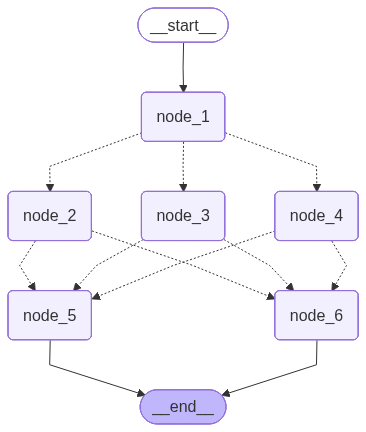

In [25]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)
builder.add_node("node_5", node_5)
builder.add_node("node_6", node_6)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_genre)
builder.add_conditional_edges("node_2", decide_reading_time)
builder.add_conditional_edges("node_3", decide_reading_time)
builder.add_conditional_edges("node_4", decide_reading_time)
builder.add_edge("node_5", END)
builder.add_edge("node_6", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
graph.invoke(PydanticState(name="Riya",genre="horror",reading_time="long"))

---Node 1:Lets pick a book to read---
---Node 2: Horror Section---
---Node 6: Long Read---


{'name': 'Riya is browsing the library... ',
 'genre': 'horror',
 'reading_time': 'long'}